# Módulo 1 - Tarea 1

Construir un clasificador MLP para predecir la clase de un documento de texto del corpus *20newsgroups* ([más información](http://qwone.com/~jason/20Newsgroups/)), el cual ya ha sido usado varias veces en clase.

Para esto, puedes usar tantas capas como desees, además, puedes modificar el número de neuronas, hacer dropout, usar callbacks y gridsearch (puede ser muy tardado). La función de perdida para la clasificación multiclase que usaremos es `categorical_crossentropy` y la métrica de rendimiento será el accuracy.

Una vez que tengas tu mejor modelo posible respecto al accuracy, reportar también las métricas:

* Recall
* Precision
* Roc-Auc score
* La matriz de confusión

**Fecha de entrega: Domingo 25 de junio**

En el siguiente link puedes encontrar las mejores accuracy que se han logrado, así como la estrategia. https://paperswithcode.com/sota/text-classification-on-20news

No es realista esperar obtener resultados de ese orden puesto que se trata de un problema no trivial. En sesiones posteriores iremos mejorando este resultado con algunas redes más especializadas.

* https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

* https://github.com/rshah204/Text-Analytics-20-Newsgroups-Dataset/blob/master/2.%20ProjectCodeNeuralNetwork.ipynb

## 1. Obtener el dataset

In [1]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np

full_data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'),
                               subset='all'
                              )


docs = full_data.data
y = full_data.target
n_classes = np.unique(y).shape[0]

## 2. Obtención de features

Para obtener las features de cada documento usaremos dos estrategias:

1. El módelo bolsa de palabras (*Bag of words: BOW*). Para esto usaremos la clase `CountVectorizer` de scikit-learn.
2. El módelo TF-IDF. Para esto usaremos la clase `TfidfVectorizer` de scikit-learn. Los detalles de este modelo los puedes ver en la notebook de [clustering](https://github.com/DCDPUAEM/DCDP/blob/main/02-Machine-Learning/notebooks/12-Clustering.ipynb) del módulo pasado.

Además, limpiaremos el texto y lematizaremos.

> La lematización es un proceso lingüístico que consiste en, dada una forma flexionada (es decir, en plural, en femenino, conjugada, etc), hallar el lema correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra. Es decir, el lema de una palabra es la palabra que nos encontraríamos como entrada en un diccionario tradicional: singular para sustantivos, masculino singular para adjetivos, infinitivo para verbos. Por ejemplo, decir es el lema de dije, pero también de diré o dijéramos; guapo es el lema de guapas; mesa es el lema de mesas.



Bajamos las *stopwords*, signos de puntuación y el módulo *wordnet* (usado para sinónimos y lematización).

In [2]:
import nltk
from nltk import download

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Limpiamos el texto quitando signos de puntuación, números, símbolos especiales y pasando todo a minúsculas. Usamos la función que ya habíamos definido en el módulo pasado.

In [3]:
url = "https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/02-Machine-Learning/data/limpiador_texto.py"
!wget --no-cache --backups=1 {url}

--2023-07-01 14:54:55--  https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/02-Machine-Learning/data/limpiador_texto.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 651 [text/plain]
Failed to rename limpiador_texto.py to limpiador_texto.py.1: (2) No such file or directory
Saving to: ‘limpiador_texto.py’

limpiador_texto.py  100%[===================>]     651  --.-KB/s    in 0s      

2023-07-01 14:54:56 (25.1 MB/s) - ‘limpiador_texto.py’ saved [651/651]



In [4]:
from limpiador_texto import preprocesar_textos

clean_docs = preprocesar_textos(docs)

Veamos como va el corpus hasta el momento

In [5]:
import pandas as pd

docs_df = pd.DataFrame(data={'document': clean_docs,
                             'class': y})
docs_df

,document,class
0,sure bashers pens fans pretty confused lack ki...,10
1,brother market highperformance video card supp...,3
2,finally said dream mediterranean new area grea...,17
3,think scsi card dma transfers disks scsi card ...,3
4,old jasmine drive use new system understanding...,4
...,...,...
18841,dn nyedacnsvaxuwecedu david nye dn neurology d...,13
18842,isolated ground recepticles usually unusual co...,12
18843,installed dx cpu clone motherboard tried mount...,3
18844,wouldnt require hypersphere space points speci...,1


Lematizamos

In [6]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return(" ".join([lemmatizer.lemmatize(w,"v") for w in w_tokenizer.tokenize(text)]))

docs_df["lemmatized_document"] = docs_df['document'].apply(lemmatize_text)
docs_df

,document,class,lemmatized_document
0,sure bashers pens fans pretty confused lack ki...,10,sure bashers pen fan pretty confuse lack kind ...
1,brother market highperformance video card supp...,3,brother market highperformance video card supp...
2,finally said dream mediterranean new area grea...,17,finally say dream mediterranean new area great...
3,think scsi card dma transfers disks scsi card ...,3,think scsi card dma transfer disk scsi card dm...
4,old jasmine drive use new system understanding...,4,old jasmine drive use new system understand up...
...,...,...,...
18841,dn nyedacnsvaxuwecedu david nye dn neurology d...,13,dn nyedacnsvaxuwecedu david nye dn neurology d...
18842,isolated ground recepticles usually unusual co...,12,isolate grind recepticles usually unusual colo...
18843,installed dx cpu clone motherboard tried mount...,3,instal dx cpu clone motherboard try mount cpu ...
18844,wouldnt require hypersphere space points speci...,1,wouldnt require hypersphere space point specif...


Creamos una lista con los documentos preprocesados

In [7]:
clean_docs = list(docs_df["lemmatized_document"].values)

## 3. El modelo

In [8]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer

def build_model(input_shape,layer_sizes,n_classes):
    model = Sequential()
    model.add(InputLayer(input_shape))
    for n in layer_sizes:
        model.add(Dense(n,activation='relu'))
    model.add(Dense(n_classes,activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [9]:
import matplotlib.pyplot as plt

def plot_training(history):
    # ---- graficamos la función de perdida ----
    plt.figure(figsize=(11,5))
    plt.suptitle("Training Curves",fontsize=14)
    ax1 = plt.subplot(1,2,1)
    ax1.set_title("Loss")
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')
    plt.legend()
    # ---- graficamos la métrica de rendimiento ----
    ax2 = plt.subplot(1,2,2)
    ax2.set_title("Accuracy")
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='validation')
    plt.legend()
    plt.show()

In [10]:
from tensorflow.keras.utils import to_categorical

Y = to_categorical(y, num_classes=n_classes)
Y.shape

(18846, 20)

# TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(stop_words='english',
                             max_features=800)
X_tfidf = vectorizer.fit_transform(clean_docs)
X_tfidf = np.asarray(X_tfidf.todense())
print(X_tfidf.shape)

(18846, 800)


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf,Y,train_size=0.8,random_state=505)

In [13]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',patience=4,verbose=1)

In [14]:
layer_sizes = [1500]

model = build_model(X_train.shape[1],layer_sizes,n_classes)

history = model.fit(X_train,Y_train,validation_split=0.15,
                    epochs=100,
                    callbacks=[es],
                    verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1500)              1201500   
                                                                 
 dense_1 (Dense)             (None, 20)                30020     
                                                                 
Total params: 1,231,520
Trainable params: 1,231,520
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
401/401 [==============================] - 11s 24ms/step - loss: 1.8325 - accuracy: 0.4848 - val_loss: 1.3902 - val_accuracy: 0.5778
Epoch 2/100
401/401 [==============================] - 8s 21ms/step - loss: 1.2056 - accuracy: 0.6240 - val_loss: 1.3780 - val_accuracy: 0.5800
Epoch 3/100
401/401 [==============================] - 8s 19ms/step - loss: 1.0410 - accuracy: 0.6725 - val_loss: 1.4168 - val_accuracy: 0.5707
Epoc

Test accuracy: 0.5429708361625671


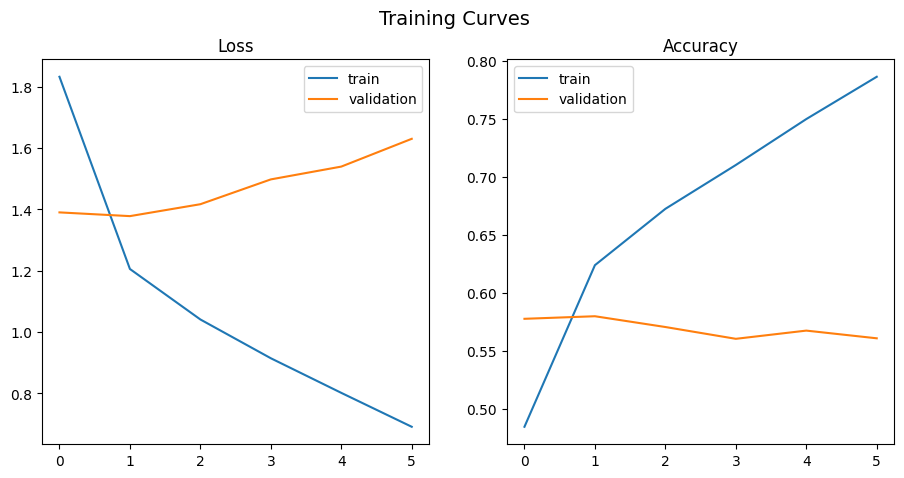

In [15]:
print(f"Test accuracy: {model.evaluate(X_test,Y_test,verbose=0)[1]}")
plot_training(history)

## PCA

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [17]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',patience=1,verbose=1)

layer_sizes = [1500]

model = build_model(X_train.shape[1],layer_sizes,n_classes)

history = model.fit(X_train,Y_train,validation_split=0.15,
                    epochs=100,
                    callbacks=[es],
                    verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1500)              151500    
                                                                 
 dense_3 (Dense)             (None, 20)                30020     
                                                                 
Total params: 181,520
Trainable params: 181,520
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
401/401 [==============================] - 4s 10ms/step - loss: 2.0206 - accuracy: 0.4508 - val_loss: 1.5645 - val_accuracy: 0.5203
Epoch 2/100
401/401 [==============================] - 2s 6ms/step - loss: 1.5534 - accuracy: 0.5208 - val_loss: 1.5078 - val_accuracy: 0.5336
Epoch 3/100
401/401 [==============================] - 3s 6ms/step - loss: 1.5011 - accuracy: 0.5311 - val_loss: 1.5097 - val_accuracy: 0.5309
Epoch 3: 

Test accuracy: 0.519098162651062


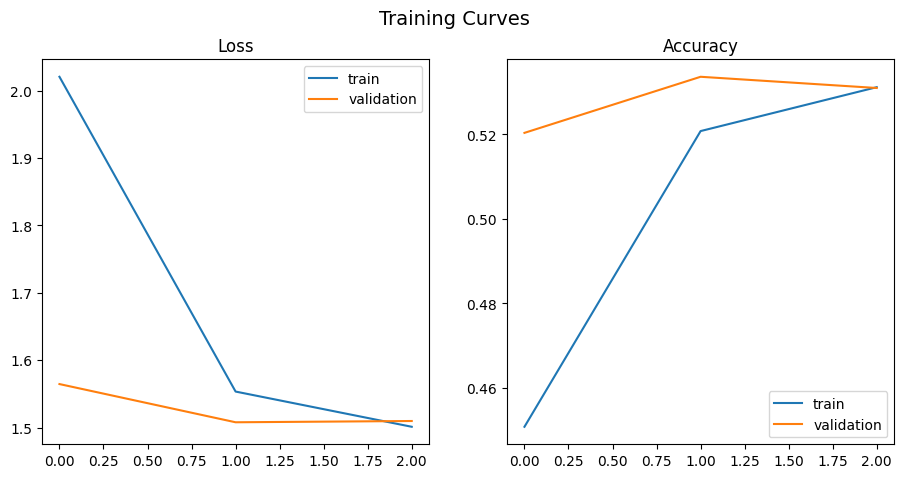

In [18]:
print(f"Test accuracy: {model.evaluate(X_test,Y_test,verbose=0)[1]}")

plot_training(history)

# CountVectorizer

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english',
                                    max_features=500)
X_counts = count_vectorizer.fit_transform(clean_docs)
X_counts =  np.asarray(X_counts.todense())
print(X_counts.shape)

(18846, 500)


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_counts,Y,train_size=0.8,random_state=505)

In [21]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',patience=1,verbose=1)

layer_sizes = [10,10,10,10]

model = build_model(X_train.shape[1],layer_sizes,n_classes)

history = model.fit(X_train,Y_train,validation_split=0.15,
                    epochs=100,
                    callbacks=[es],
                    verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                5010      
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 20)                220       
                                                                 
Total params: 5,560
Trainable params: 5,560
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
401/401 [==========================

Test accuracy: 0.38726791739463806


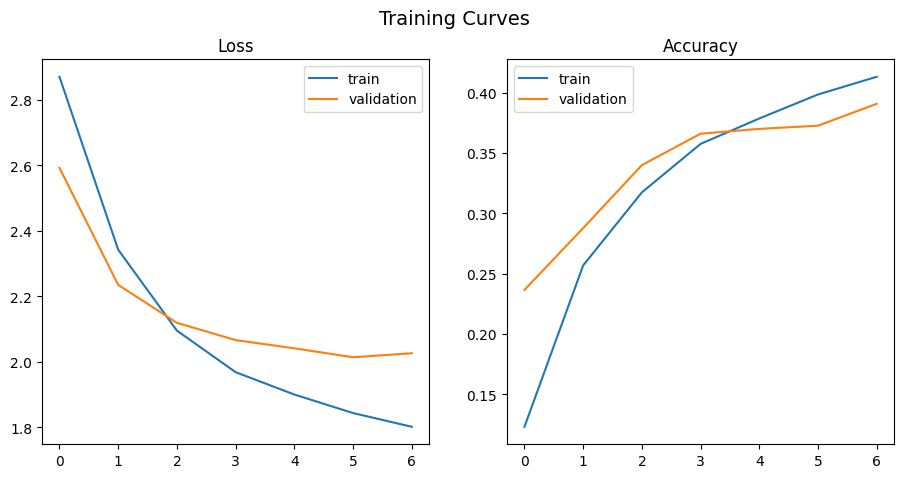

In [22]:
print(f"Test accuracy: {model.evaluate(X_test,Y_test,verbose=0)[1]}")

plot_training(history)

##PCA

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [24]:
es = EarlyStopping(monitor='val_loss',patience=1,verbose=1)

layer_sizes = [10,10,10,10]

model = build_model(X_train.shape[1],layer_sizes,n_classes)

history = model.fit(X_train,Y_train,validation_split=0.15,
                    epochs=100,
                    callbacks=[es],
                    verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 10)                110       
                                                                 
 dense_12 (Dense)            (None, 10)                110       
                                                                 
 dense_13 (Dense)            (None, 20)                220       
                                                                 
Total params: 1,560
Trainable params: 1,560
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
401/401 [==========================

Test accuracy: 0.3578249216079712


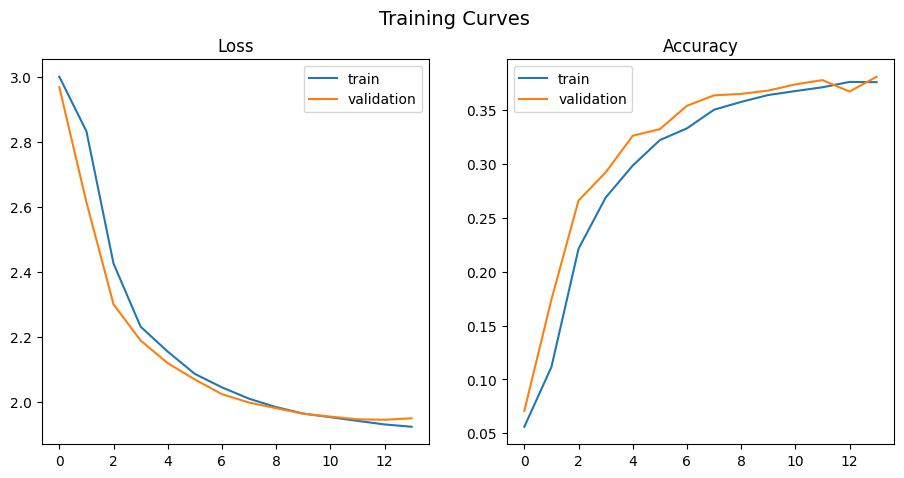

In [25]:
print(f"Test accuracy: {model.evaluate(X_test,Y_test,verbose=0)[1]}")

plot_training(history)